# Диффузионные модели

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mryab/dl-hse-ami/blob/main/week10_probmodels/homework.ipynb)

#### Разработчик: Аким Котельников

План задания: пишем свою диффузионную модель и тестируем её на SwissRoll-ах (50% баллов), далее запускаем её на MNIST (20%), затем пишем DDIM и проверям его на MNIST (30%). Цель задания: разобраться как работают диффузионные модели, разобраться в формулах. При этом проблем с обучением моделей почти быть не должно. Формат: дозаполнить "todo".

### Импорты и SwissRoll-ы

In [1]:
!wget --quiet --show-progress "https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall23/homework04/utils.py"

utils.py            100%[===================>]   6,55K  --.-KB/s    за 0s      


In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.datasets import make_swiss_roll
from sklearn.utils import shuffle

In [2]:
SEED = 777

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
from sklearn.datasets import make_circles, make_swiss_roll


def make_swiss_dataset(num_samples):
    X0, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X1, _ = make_swiss_roll(num_samples // 2, noise=0.3, random_state=0)
    X0 = X0[:, [0, 2]]
    X1 = X1[:, [0, 2]]
    X1 = -X1
    X, y = shuffle(
        np.concatenate([X0, X1], axis=0),
        np.concatenate([np.zeros(len(X0)), np.ones(len(X1))], axis=0),
        random_state=0)
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, y

X, y = make_swiss_dataset(2000)

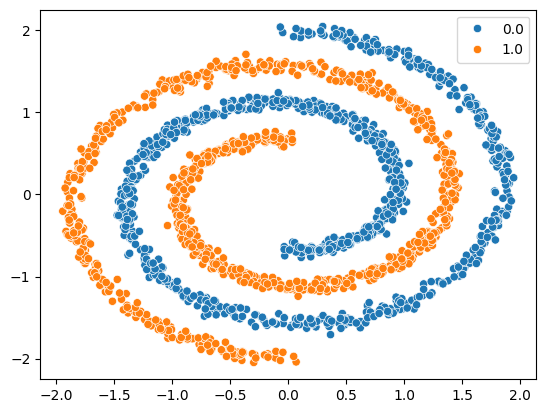

In [4]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y);

## DDPM (0.5 баллов)

В данной части вам предстоит написать собстевнную диффузионную модель (DDPM) и протестировать её на датасете выше. 

### Напоминание

Напомним, что диффузионная модель состоит из прямого и обратного процесса. Прямой диффузионный процесс определяется как апостериорное распределение $q(x_{1:T}|x_0)$. Это распределение также является Марковской цепочкой, которая постепенно добавляет гауссовский шум к данному начальному объекту $x_0$. На каждом шаге шум добавляется с различной магнитудой, которая определяется расписанием дисперсий
 $\{\beta_1, ... \beta_T\}$. При правильном выборе расписания в пределе по числу шагов $T$ мы должны сойтись к шуму из $\mathcal{N}(0, I)$. В качестве распределений $q$ берут нормальные распределения: 
$$
 q(x_t | x_{t - 1}) := \mathcal{N}(x_t; \sqrt{1 - \beta_t}x_{t - 1}, \beta_tI), \ \ \ \ \ \ \ q(x_{1:T}|x_0) = \prod_{t = 1}^T q(x_t | x_{t - 1})
$$

Теперь посмотрим со стороны обратного процесса. Обратный процесс расшумляет шум, пока не получится объект из изначального распределения. Таким образом, диффузионная модель - это вероятностная модель с латентными переменными вида $p_\theta(x_0) := \int p_\theta(x_{0:T}) dx_{1:T}$, где промежуточные состояния $x_1, ..., x_T$ соответствуют зашумленным объектам, a $x_0$ - объект из распределения. Совместное распределение $p_\theta(x_{0:T})$ называет обратным диффузионным процессом, который представляет собой Марковскую цепочку из гауссовских распределений $p_\theta(x_{i-1}|x_{i})$: 

$$
p(x_{0:T}) = p(x_0) \prod_{t = 1}^Tp_{\theta}(x_{t-1}|x_t) \ \ \ \ \ \ \ \ \ p_\theta(x_{T})=\mathcal{N}(x_T | 0, I)
$$
$$
  p_{\theta}(x_{t - 1}|x_t):= \mathcal{N}(x_{t - 1}; \mu_{\theta}(x_t, t), \Sigma_{\theta}(x_t, t))
$$

Вернемся к распределению $q(x_t | x_{t - 1})$.  Для того чтобы получить $x_t$, придется итеративно получать $x_1, ..., x_{t - 1}$. Однако это можно сделать более эффективно благодаря нормальным распределениям. Для этого обозначим $\alpha_t := 1- \beta_t$ и $\bar{\alpha}_t:= \prod_{i = 1}^t\alpha_i$, тогда 
$$
q(x_t | x_0) = \mathcal{N}(x_t;\sqrt{\bar{\alpha}_t} x_0, (1-\bar{\alpha}_t)I) \quad \quad \quad \quad \quad \quad (1)
$$

Затем модель можно обучать, оптимизируя отдельные члены суммы вариационной нижней оценки $\log p_{\theta}(x_0)$:
$$
L_{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(\mathbf{x}_T | 
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_T))}_{L_T} + + \sum_{t=2}^T 
\underbrace{D_\text{KL}(q(\mathbf{x}_{t-1} | \mathbf{x}_t, 
\mathbf{x}_0) \parallel p_\theta(\mathbf{x}_{t-1} 
| \mathbf{x}_t))}_{L_{t-1}} \underbrace{- \log p_\theta(\mathbf{x}_0 
| \mathbf{x}_1)}_{L_0}
$$

Для обучение нужно лишь выписать $q(\mathbf{x}_{t-1} | \mathbf{x}_t, \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_{t-1}; \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0), \tilde{\beta}_t \mathbf{I}) $: 

$$
    \boldsymbol{\mu}(\mathbf{x}_t, \mathbf{x}_0) = \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} \mathbf{x}_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \mathbf{x}_0 \ \ \ \ \ \ (2)
$$
$$
    \tilde{\beta}_t = \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t  \quad \quad \quad \quad \quad \quad \quad (3)
$$


За подробностями читайте статью [Denoising Diffusion Probabilistic Models (Ho et al. 2020)](https://arxiv.org/abs/2006.11239). 

Тем не менее в упомянутой статье было показано, что обучаясь на более простой лосс, получаются результаты лучше.  

Итак, заметим, что
$$
x_t(x_0, \epsilon) = \sqrt{\bar{\alpha}_t} x_0 +  \sqrt{1-\bar{\alpha}_t}\epsilon, \ \ \ \epsilon \sim \mathcal{N}(0, I) \quad \quad \quad \quad \quad \quad \quad (4)
$$

Тогда пускай наша модель с весами $\theta$ будет предсказывать $\epsilon$ из равенства выше, а именно обучаться, минимизируя данную функцию потерь: 

$$L^{simple}_t = \mathbb{E}_{x_0, \epsilon, t}\bigg[ \|\epsilon - \epsilon_{\theta}(x_t, t)\|^2\bigg]$$

Именно этот лосс вы должны будете использовать.


Чтобы сэмплировать (обратный процесс), нам нужно получить $\mu_{\theta}(x_t, x_0)$ из $\epsilon_{\theta}(x_t, t)$. Для этого получите $\hat{x}_0(\epsilon_{\theta}, x_t)$ из уравнения (4) и подставьте его в равенство (2):

**TODO**: выпишите формулу для $\mu_{\theta}(x_t, x_0)$ (она понадобится, чтобы закодить ниже функцию p_mean_variance())

Переходим к заданию. Ниже будут представлены две вспомогательные функции, которые вам понадобятся.

In [5]:
# some functions you will need

import math


# utility function. basically, returns arr[timesteps], where timesteps are indices. (look at class Diffusion)
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D torch tensor for a batch of indices.
    :param arr: 1-D torch tensor.
    :param timesteps: a tensor of indices into torch array to extract. (shape is [batch_size])
    :param broadcast_shape: a larger shape of K dimensions; output shape will be broadcasted to this
                            by adding new dimensions of size 1.
                            the first dimension of output tensor will be equal to length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where tensor shape has K dims.
    """
    res = arr.to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

# out beta_t. we use linear scheduler
def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    """
    Get a pre-defined beta schedule for the given name.
    The beta schedule library consists of beta schedules which remain similar
    in the limit of num_diffusion_timesteps.
    Beta schedules may be added, but should not be removed or changed once
    they are committed to maintain backwards compatibility.
    """
    scale = 1000 / num_diffusion_timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02 
    if schedule_name == "linear":
        # Linear schedule from Ho et al, extended to work for any number of
        # diffusion steps.
        return np.linspace(
            beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64
        )
    elif schedule_name == "quad":
        betas = torch.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps) ** 2
        return betas.numpy()
    elif schedule_name == "sigmoid":
        betas = torch.linspace(-6, 6, num_diffusion_timesteps)
        betas = torch.sigmoid(betas) * (beta_end - beta_start) + beta_start
        return betas.numpy()
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

### Класс Diffusion (0.3 балла из 0.5 за DDPM)
Вам нужно дописать недостающие части ниже (помечены todo).

In [6]:
from tqdm.auto import tqdm


class Diffusion:
    def __init__(
        self,
        *,
        betas: np.array,
        loss_type: str = "mse"
    ):
        """
        Class that simulates Diffusion process. Does not store model or optimizer.
        """
        self.loss_type = loss_type

        betas = torch.from_numpy(betas).double()
        self.betas = betas
        assert len(betas.shape) == 1, "betas must be 1-D"
        assert (betas > 0).all() and (betas <= 1).all()

        self.num_timesteps = int(betas.shape[0])

        alphas = 1 - betas
        self.alphas_cumprod = torch.cumprod(alphas, dim=0)
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.0]), self.alphas_cumprod[:-1]], dim=0)  # \bar\alpha_{t-1}
        self.alphas_cumprod_next = torch.cat([self.alphas_cumprod[1:], torch.tensor([0.0]), ], dim=0)  # \bar\alpha_{t+1}
        assert self.alphas_cumprod_prev.shape == (self.num_timesteps,)

        # calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = self.alphas_cumprod.sqrt()
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = torch.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / self.alphas_cumprod - 1)


        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (1 - self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod)

        # log calculation clipped because posterior variance is 0.
        self.posterior_log_variance_clipped = torch.log(
            torch.cat([self.posterior_variance[1:2], self.posterior_variance[1:]], dim=0)
        )
        self.posterior_mean_coef1 = torch.sqrt(alphas) * (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod)
        self.posterior_mean_coef2 = torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1 - self.alphas_cumprod)

    def q_mean_variance(self, x0, t):
        """
        Get mean and variance of distribution q(x_t | x_0) for specific x_0 and t. Use equation (1).
        """
        mean = _extract_into_tensor(self.sqrt_alphas_cumprod, t, x0.shape) * x0
        variance = _extract_into_tensor(1 - self.alphas_cumprod, t, x0.shape)
        log_variance = torch.log(variance)

        return mean, variance, log_variance

    def q_posterior_mean_variance(self, x_start, x_t, t):
        """
        Compute mean and variance of diffusion posterior q(x_{t-1} | x_t, x_0) for specific x_t and t.
        Use equation (2) and (3).

        x_start is x_0 in formulas
        """
        assert x_start.shape == x_t.shape
        posterior_mean = (_extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_t +
                          _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_0)
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def q_sample(self, x_start, t, noise=None):
        """
        Diffuse data for a given number of diffusion steps.
        Sample from q(x_t | x_0).
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        mean, variance, log_variance = self.q_mean_variance(x_start, t)
        return noise * torch.exp(0.5 * log_variance) + mean

    def _predict_xstart_from_eps(self, x_t, t, eps):
        """
        Get \hat{x0} from epsilon_{theta}. Use equation (4) to derive it.
        """
        coef_1 = _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, eps.shape)
        coef_2 = _extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, eps.shape)
        return (x_t - coef_1 * eps) * coef_2

    def p_mean_variance(self, model_output, x, t):
        """
        Apply model to get p(x_{t-1} | x_t). Use Equation (2) and plug in \hat{x}_0;
        """
        model_variance = torch.cat([self.posterior_variance[1:2], self.betas[1:]], dim=0)
        model_log_variance = torch.log(model_variance)
        model_variance = _extract_into_tensor(model_variance, t, x.shape)
        model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        pred_xstart = self._predict_xstart_from_eps(x, t, model_output)
        
        posterior_mean_coef1 = _extract_into_tensor(self.posterior_mean_coef1, t, x.shape)
        posterior_mean_coef2 = _extract_into_tensor(self.posterior_mean_coef2, t, x.shape)
    
        model_mean = posterior_mean_coef1 * x + posterior_mean_coef2 * pred_xstart

        return {
            "mean": model_mean,
            "variance": model_variance,
            "log_variance": model_log_variance,
            "pred_xstart": pred_xstart,
        }

    def p_sample(self, model_output, x, t):
        """
        Sample from p(x_{t-1} | x_t).
        """
        out = self.p_mean_variance(model_output, x, t)
        noise = torch.randn_like(x)
        nonzero_mask = torch.tile(torch.where(t == 0, 0, 1), (x.shape[1],1)).T
        if t.sum() == 0:
            nonzero_mask = 0.
        else:
            nonzero_mask = 1.
            
        sample = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample}

    def p_sample_loop(self, model, shape, y_dist):
        """
        Samples a batch=shape[0] using diffusion model.
        """
        x = torch.randn(*shape)
        indices = list(range(self.num_timesteps))[::-1]

        y = torch.multinomial(
            y_dist,
            num_samples=shape[0],
            replacement=True
        ).to(x.device)
        
        for i in tqdm(indices):
            t = torch.tensor([i] * shape[0], device=x.device)
            with torch.no_grad():
                model_output = model(x.double().to(device), t.to(device), y.to(device)).cpu()
                out = self.p_sample(
                    model_output,
                    x,
                    t
                )
                x = out["sample"]
        return x, y

    def train_loss(self, model, x0, y):
        """
        Calculates loss L^{simple}_t for the given model, x0.
        """
        t = torch.randint(0, self.num_timesteps, size=(x0.size(0),), device=x0.device)
        noise = torch.randn_like(x0)
        x_t = self.q_sample(x0, t, noise)
        model_output = model(x_t.double().to(device), t.to(device), y.to(device)).cpu()
        if self.loss_type == 'mse':
            loss = ((noise - model_output) ** 2).mean()
        else:
            raise NotImplementedError
        return loss

In [7]:
T = 100

diffusion = Diffusion(
    betas=get_named_beta_schedule('linear', T),
    loss_type="mse"
)

In [8]:
import matplotlib.pyplot as plt


def show_noising(diffusion, X, y):
    fig, axs = plt.subplots(1, 10, figsize=(40, 5))
    for i, t in enumerate(range(0, diffusion.num_timesteps, 10)):
        x = diffusion.q_sample(
           x_start=torch.from_numpy(X),
            t=torch.ones_like(torch.from_numpy(y)).long() * t,
        )
        sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, ax=axs[i])
        axs[i].set(title=t)

Давайте посмотрим, как зашумляются наши данные с увеличением $t$. Как думаете, достаточно ли $T = 100$ или надо увеличить? Как можно понять, сколько достаточно? (не оценивается)

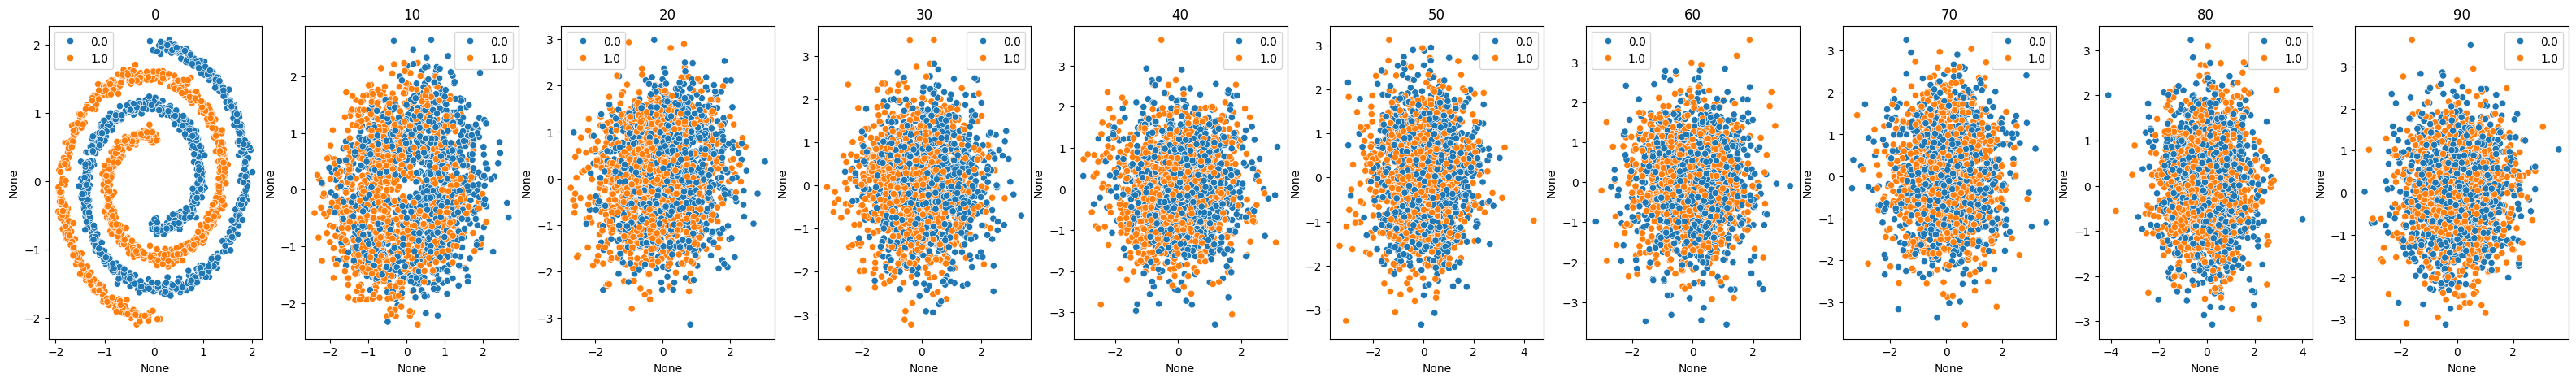

In [9]:
show_noising(diffusion, X, y)

### Модель (0.1 балл из 0.5 за DDPM)

Тут мы реализуем модель с весами $\theta$, которая параметризует обратный процесс. Модель не должна быть сложной и большой. Достаточно только линейных слоев. Не забудьте учесть классы $y$ и шаги $t$. Модель предсказывает шум $\epsilon: \epsilon_{\theta}(x_t, t, y)$

In [10]:
class DiffModel(nn.Module):
    def __init__(self, d_in, num_emb=2):
        super().__init__()

        self.hidden = 128

        # one may use a simple model that projects x, t into space of size self.hidden, 
        # transforms y label into space of size self.hidden, sum all the vectors and postprocess it with MLP

        self.time_embed = nn.Embedding(100, 20)
        self.y_embed = nn.Embedding(num_emb, 20)
        
        self.x_proj = nn.Sequential(
            nn.Linear(d_in, self.hidden),
            nn.ReLU()
        )
        self.t_proj = nn.Sequential(
            nn.Linear(20, self.hidden),
            nn.ReLU()
        )
        
        self.layers = nn.Sequential(
            nn.Linear(self.hidden, 4 * self.hidden),
            nn.ReLU(),
            nn.Linear(4 * self.hidden, num_emb),
        )

    def forward(self, x, t, y):
        '''
        :x input, e.g. images
        :t 1d torch.LongTensor of timesteps
        :y 1d torch.LongTensor of class labels
        '''
        
        t = self.y_embed(y) + self.time_embed(t)
        
        x = self.x_proj(x) + self.t_proj(t)
        return self.layers(x)

In [11]:
device = torch.device('cuda')
model = DiffModel(d_in=2).double().to(device)
model.device = device

### Обучение модели (0.1 балл из 0.5 за DDPM)

Наконец, обучим нашу модель. Ниже за вас написан класс `Trainer`, который хранит модель, диффузию и оптимайзер. Вам надо лишь дописать функцию `_run_step`

In [12]:
from copy import deepcopy

import pandas as pd


class Trainer:
    def __init__(
        self,
        diffusion: Diffusion,
        model: nn.Module,
        train_iter, # iterable that yields (x, y)
        lr: float,
        weight_decay: float,
        steps: int,
        device: torch.device = torch.device('cpu'),
        print_every = 500
    ):
        self.diffusion = diffusion

        self.train_iter = train_iter
        self.steps = steps
        self.init_lr = lr
        self.model = model
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        self.device = device
        self.log_every = 100
        self.print_every = print_every

    def _anneal_lr(self, step: int):
        """
        Performs annealing of lr.
        """

        frac_done = step / self.steps
        lr = self.init_lr * (1 - frac_done)
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    def _run_step(self, x: torch.FloatTensor, y: torch.LongTensor):
        """
        A single training step.
        Calculates loss (using Diffusion.train_loss() )for a single batch. 
        Then performs a single optimizer step (don't forget to zero grad) and returns loss.
        """
        self.optimizer.zero_grad()
        loss = self.diffusion.train_loss(self.model, x, y)
        loss.backward()
        self.optimizer.step()
        return loss

    def run_loop(self):
        """
        Training loop.
        """
        curr_loss_gauss = 0.0

        curr_count = 0
        for step in tqdm(range(self.steps)):
            x, y = next(self.train_iter)
            batch_loss = self._run_step(x, y)

            self._anneal_lr(step)

            curr_count += len(x)
            curr_loss_gauss += batch_loss.item() * len(x)

            if (step + 1) % self.log_every == 0:
                gloss = np.around(curr_loss_gauss / curr_count, 4)
                if (step + 1) % self.print_every == 0:
                    print(f'Step {(step + 1)}/{self.steps} Loss: {gloss}')
                curr_count = 0
                curr_loss_gauss = 0.0


Теперь обернем наши данные в `DataLoader`. Для этого за вас написан `FastTensorDataLoader`. Также у нас идет обучение не по эпохам, а по итерациям, поэтому нам нужен "бесконечный" итератор.

In [13]:
from utils import FastTensorDataLoader


def get_data_iter(X: np.array, y: np.array, batch_size: int = 512):
    X = torch.from_numpy(X).float()
    y = torch.from_numpy(y).long()
    dataloader = FastTensorDataLoader(X, y, batch_size=batch_size, shuffle=True)
    while True:
        yield from dataloader
    
data_iter = get_data_iter(X, y)

In [14]:
# you can change hyperparameters
trainer = Trainer(
    diffusion,
    model,
    train_iter=data_iter,
    lr=0.01,
    weight_decay=0.0,
    steps=10_000
)

In [15]:
trainer.run_loop() # < 1min

  0%|          | 0/10000 [00:00<?, ?it/s]

Step 500/10000 Loss: 0.2596
Step 1000/10000 Loss: 0.2583
Step 1500/10000 Loss: 0.2566
Step 2000/10000 Loss: 0.2572
Step 2500/10000 Loss: 0.2499
Step 3000/10000 Loss: 0.2485
Step 3500/10000 Loss: 0.2419
Step 4000/10000 Loss: 0.2437
Step 4500/10000 Loss: 0.2381
Step 5000/10000 Loss: 0.2355
Step 5500/10000 Loss: 0.237
Step 6000/10000 Loss: 0.2318
Step 6500/10000 Loss: 0.2325
Step 7000/10000 Loss: 0.2336
Step 7500/10000 Loss: 0.2315
Step 8000/10000 Loss: 0.2294
Step 8500/10000 Loss: 0.2279
Step 9000/10000 Loss: 0.2272
Step 9500/10000 Loss: 0.2275
Step 10000/10000 Loss: 0.224


Теперь насэмплируем данные из нашей модели

In [16]:
from typing import List, Tuple


def sample_synthetic(
    diffusion: Diffusion,
    model: nn.Module,
    num_samples: int,
    batch: int = 1000,
    shape: Tuple = (2,),
    y_dist: List[int] = [0.5, 0.5],
    ddim: bool = False,
):
    sample_func = diffusion.p_sample_loop
    if ddim: # for the last task
        sample_func = diffusion.ddim_sample
    res_x = []
    res_y = []
    num_sampled = 0
    while num_sampled < num_samples:
        x, y = diffusion.p_sample_loop(
            model,
            shape=(batch, *shape),
            y_dist=torch.tensor(y_dist)
        )
        res_x.append(x.cpu())
        res_y.append(y.cpu())
        num_sampled += batch
    
    res_x = torch.cat(res_x, dim=0)
    res_y = torch.cat(res_y, dim=0)
    return res_x[:num_samples], res_y[:num_samples]

In [17]:
Xs, ys = sample_synthetic(diffusion, model, 1000)

  0%|          | 0/100 [00:00<?, ?it/s]

<Axes: xlabel='None', ylabel='None'>

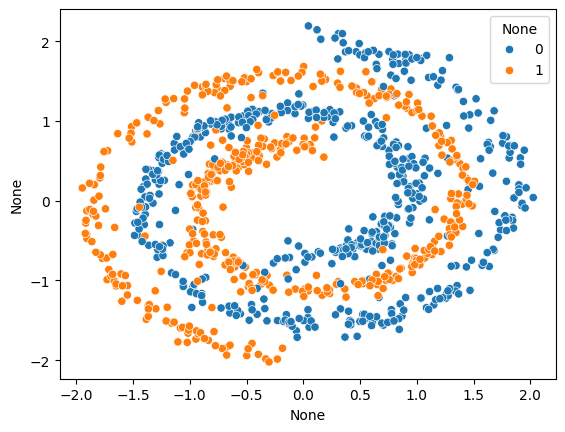

In [18]:
sns.scatterplot(x=Xs[:, 0], y=Xs[:, 1], hue=ys)

Оцените на глаз, что получилось (должно быть неплохо). Как можно численно оценить качество насэмплированных данных (именно этих данных)?  Пункт не оценивается. 

Покажите процесс расшумления аналагично тому, как мы это делали для прямого процесса

In [19]:
def show_denoising(diffusion, model, shape, y_dist):
    x = torch.randn(*shape)
    indices = list(range(diffusion.num_timesteps))[::-1]

    y = torch.multinomial(
        y_dist,
        num_samples=shape[0],
        replacement=True
    ).to(x.device)
    
    j, k = 0, 0
    fig, axs = plt.subplots(1, 11, figsize=(50, 6))
    for i in tqdm(indices):
        t = torch.tensor([i] * shape[0], device=x.device)
        with torch.no_grad():
            model_output = model(x.double().to(device), t.to(device), y.to(device)).cpu()
            out = diffusion.p_sample(model_output, x, t)
            x = out["sample"]
            
        if k % 10 == 0:
            sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, ax=axs[j])
            j += 1
        k += 1
    sns.scatterplot(x=x[:,0], y=x[:,1], hue=y, ax=axs[j])

  0%|          | 0/100 [00:00<?, ?it/s]

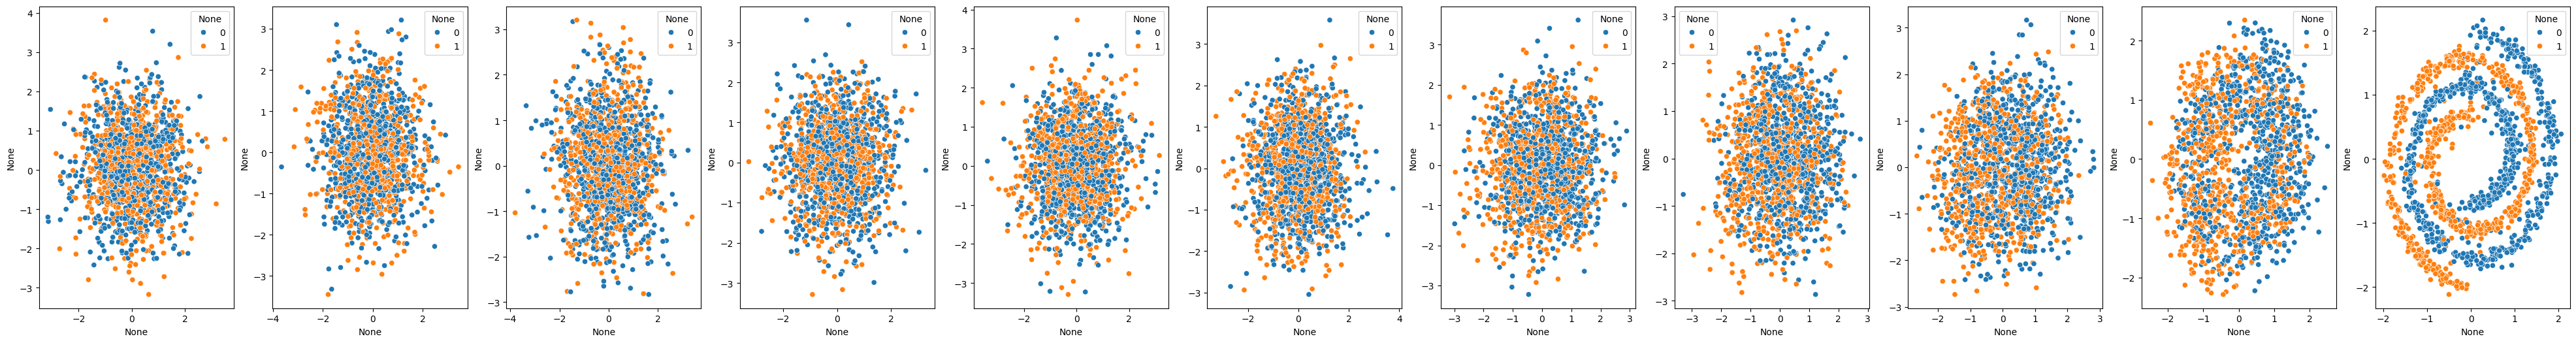

In [20]:
shape = (1500, 2)
y_dist=torch.tensor([0.5, 0.5])

show_denoising(diffusion, model, shape, y_dist)

## MNIST (0.2 балла)

Перейдём к обучению диффузионной модели на MNIST. За вас уже написана архитектура модели. В данной задаче надо лишь получить относительно *хороший* результат на датасете, используя класс `Diffusion`, а также посмотреть на разные расписание шума.

In [21]:
from torch.utils.data import DataLoader

class InfiniteDataLoader(DataLoader):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Initialize an iterator over the dataset.
        self.dataset_iterator = super().__iter__()
        
    def __iter__(self):
        return self

    def __next__(self):
        try:
            batch = next(self.dataset_iterator)
        except StopIteration:
            # Dataset exhausted, use a new fresh iterator.
            self.dataset_iterator = super().__iter__()
            batch = next(self.dataset_iterator)
        return batch

In [22]:
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import Compose, Lambda, Normalize, ToTensor

transform = Compose([
    ToTensor(),
    Normalize((0.1307,), (0.3081,))
])

dataset = MNIST("./datasets", download=True, train=True, transform=transform)
loader = InfiniteDataLoader(dataset, 512, shuffle=True)

In [23]:
def show_images(images, ys, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()
        ys = ys.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                plt.title(f"{int(ys[idx])}")
                plt.tick_params(bottom = False, labelbottom=False)
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0][:16], batch[1][:16], "Images in the first batch")
        break

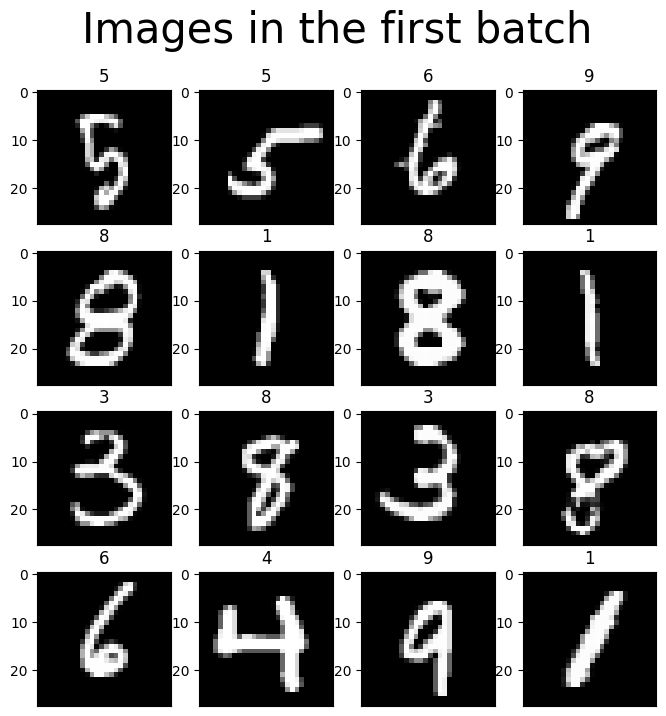

In [24]:
show_first_batch(loader)

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	NVIDIA GeForce RTX 4050 Laptop GPU


In [32]:
from utils import MyUNet

model_mnist = MyUNet().to(device).double()
model_mnist.device = device

### Смотрим на расписание шума

Прежде чем начать, постройте на одной картинке графики $\sqrt{\bar{\alpha_t}}$ (относительно $t$) для различных расписаний (linear, quad, sigmoid). Объясните, чем они отличаются. Чтобы лучше это понять визуализируйте зашумление картинок (функция `show_noising_mnist`). Советую выбрать $T = 1000$ (классический выбор, если домен -- картинки). Данный пункт оценивается.

При linear расписании картинка быстрее всего зашумляется, а при sigmoid медленнее всего. Там где при linear уже не понять что было на исходной картинке, при sigmoid ещё можно увидеть некоторые очертания исходной катринки

In [27]:
def get_alpha_bar(betas):
    plt.plot(betas)

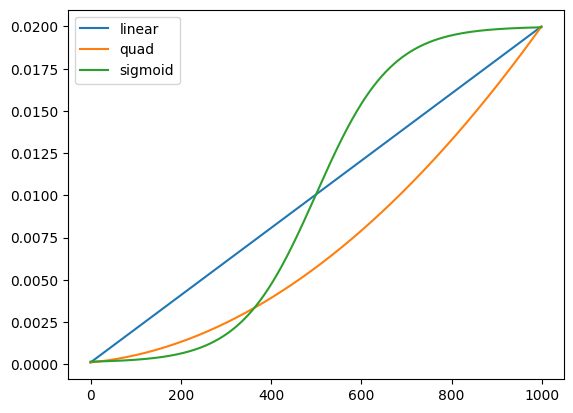

In [28]:
ts = range(1000)

# your plots here
for sch in ["linear", "quad", "sigmoid"]:
    betas = get_named_beta_schedule(sch, 1000)
    get_alpha_bar(betas)
    
plt.legend(["linear", "quad", "sigmoid"])

In [29]:
# almost the same as in the task with SwissRolls

def show_noising_mnist(diffusion, img, idx):
    for i, t in enumerate(range(0, diffusion.num_timesteps, 100)):
        x = diffusion.q_sample(
            x_start=img,
            t=torch.ones_like(img).long() * t,
        )
        fig.add_subplot(3, 10, idx + 1)
        plt.imshow(x.cpu().numpy()[0], cmap="gray")
        idx += 1
    return idx

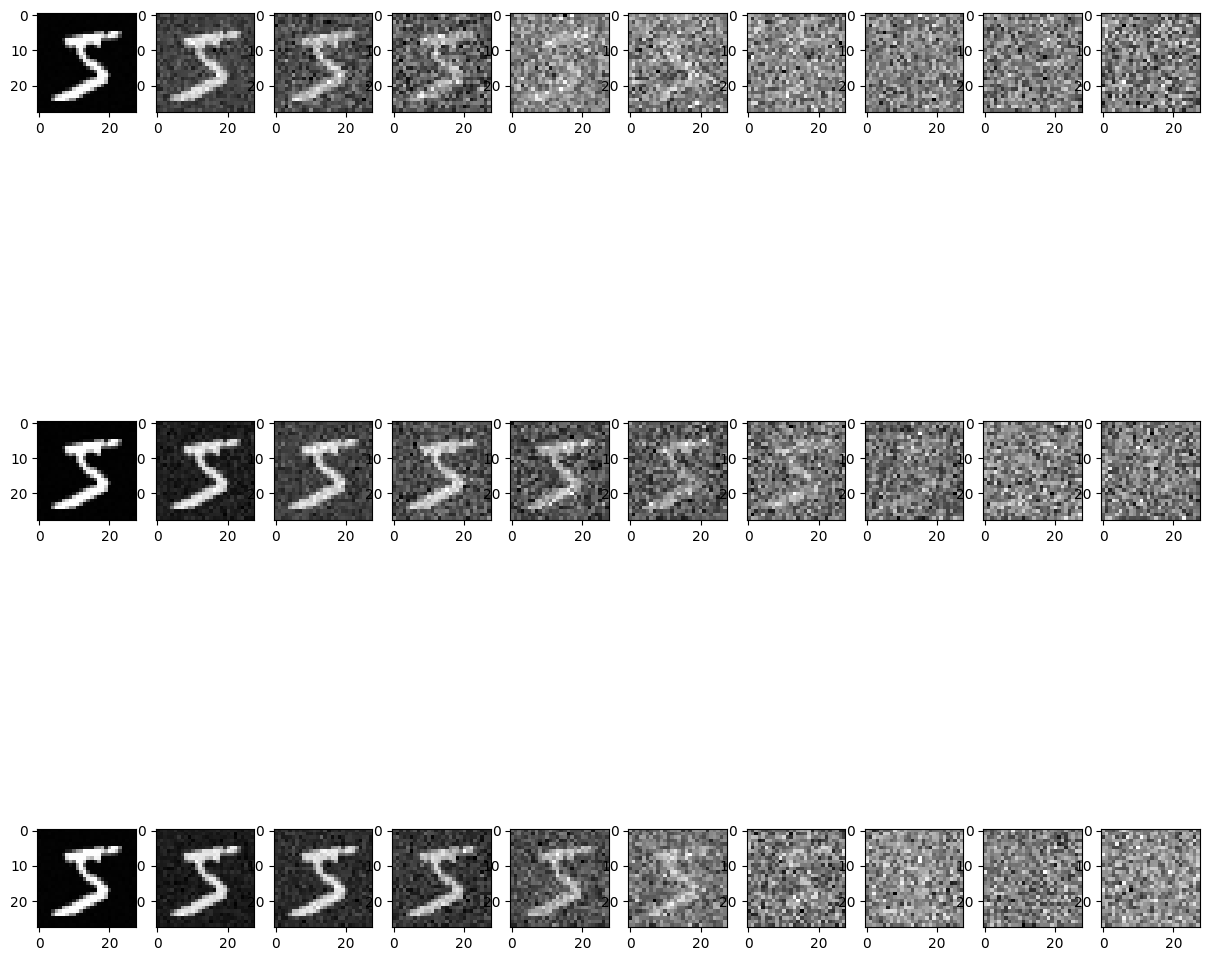

In [30]:
fig = plt.figure(figsize=(15, 15))
idx = 0
for sch in ["linear", "quad", "sigmoid"]:
    diffusion_temp = Diffusion(
       betas=get_named_beta_schedule(sch, 1000),
        loss_type="mse"
    )
    idx = show_noising_mnist(diffusion_temp, dataset[0][0], idx)
    
plt.show()

### Обучаем

In [131]:
model_mnist_sigmoid = MyUNet().to(device).double()
model_mnist_sigmoid.device = device

In [133]:
scheduler = 'sigmoid'

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist_sigmoid,
    train_iter=loader,
    lr=0.001,
    steps=1_000,
    weight_decay=0.0,
    device=device,
    print_every=100
)

In [134]:
trainer_mnist.run_loop() # <15min on 2080Ti for the author's solution

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 100/1000 Loss: 0.5077
Step 200/1000 Loss: 0.1812
Step 300/1000 Loss: 0.1243
Step 400/1000 Loss: 0.1048
Step 500/1000 Loss: 0.0946
Step 600/1000 Loss: 0.0893
Step 700/1000 Loss: 0.0851
Step 800/1000 Loss: 0.0826
Step 900/1000 Loss: 0.0809
Step 1000/1000 Loss: 0.0804


In [159]:
Xs_sigmoid, ys_sigmoid = sample_synthetic(
    diffusion_mnist,
    model_mnist_sigmoid,
    num_samples=16,
    batch = 16,
    shape=(1, 28, 28),
    y_dist = [0.1 for _ in range(10)]
)

  0%|          | 0/1000 [00:00<?, ?it/s]

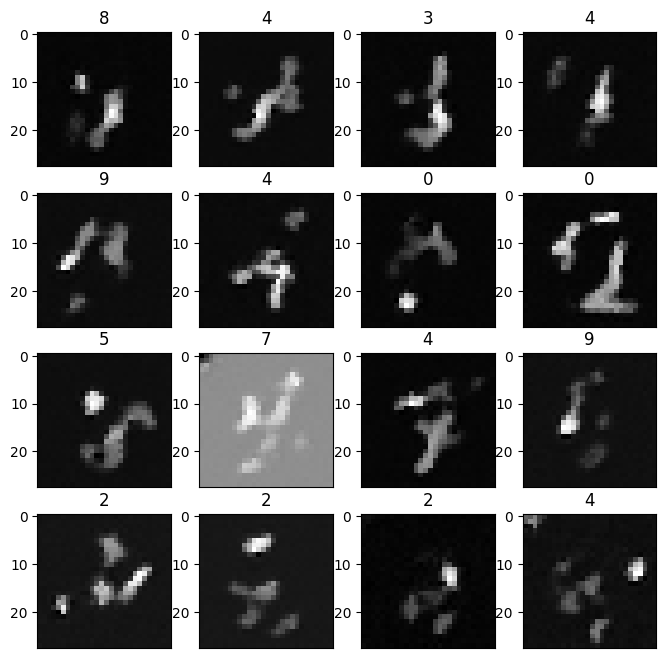

In [166]:
show_images(Xs_sigmoid, ys_sigmoid)

In [33]:
model_mnist_linear = MyUNet().to(device).double()
model_mnist_linear.device = device

scheduler = 'linear'

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist_linear,
    train_iter=loader,
    lr=0.001,
    steps=1_000,
    weight_decay=0.0,
    device=device,
    print_every=100
)

trainer_mnist.run_loop()

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 100/1000 Loss: 0.5364
Step 200/1000 Loss: 0.1687
Step 300/1000 Loss: 0.1141
Step 400/1000 Loss: 0.096
Step 500/1000 Loss: 0.0887
Step 600/1000 Loss: 0.0836
Step 700/1000 Loss: 0.0795
Step 800/1000 Loss: 0.0758
Step 900/1000 Loss: 0.0723
Step 1000/1000 Loss: 0.0715


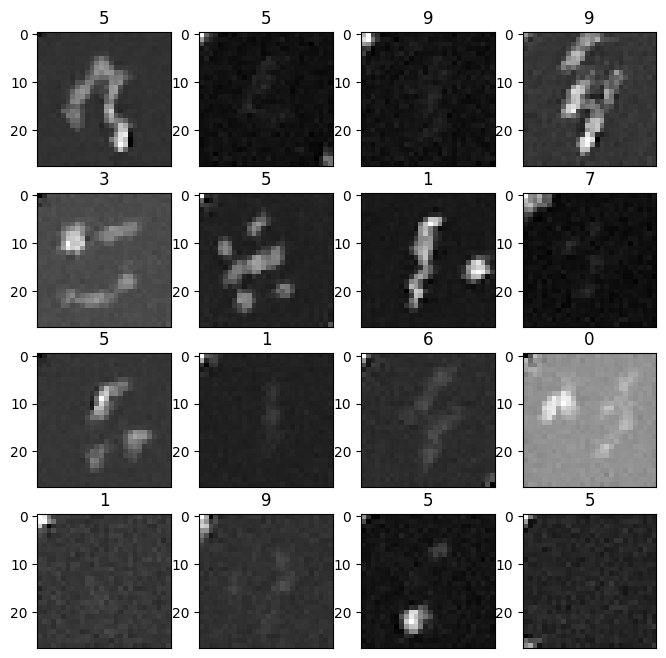

In [165]:
Xs_linear, ys_linear = sample_synthetic(
    diffusion_mnist,
    model_mnist_linear,
    num_samples=16,
    batch = 16,
    shape=(1, 28, 28),
    y_dist = [0.1 for _ in range(10)]
)
show_images(Xs_linear, ys_linear)

In [149]:
model_mnist_quad = MyUNet().to(device).double()
model_mnist_quad.device = device

scheduler = 'quad'

diffusion_mnist = Diffusion(
    betas=get_named_beta_schedule(scheduler, 1000),
    loss_type="mse"
)

# feel free to change hyperaparameters

trainer_mnist = Trainer(
    diffusion_mnist,
    model_mnist_quad,
    train_iter=loader,
    lr=0.001,
    steps=1_000,
    weight_decay=0.0,
    device=device,
    print_every=100
)

trainer_mnist.run_loop()

  0%|          | 0/1000 [00:00<?, ?it/s]

Step 100/1000 Loss: 0.5768
Step 200/1000 Loss: 0.1943
Step 300/1000 Loss: 0.1554
Step 400/1000 Loss: 0.14
Step 500/1000 Loss: 0.1318
Step 600/1000 Loss: 0.1191
Step 700/1000 Loss: 0.0998
Step 800/1000 Loss: 0.0922
Step 900/1000 Loss: 0.0893
Step 1000/1000 Loss: 0.087


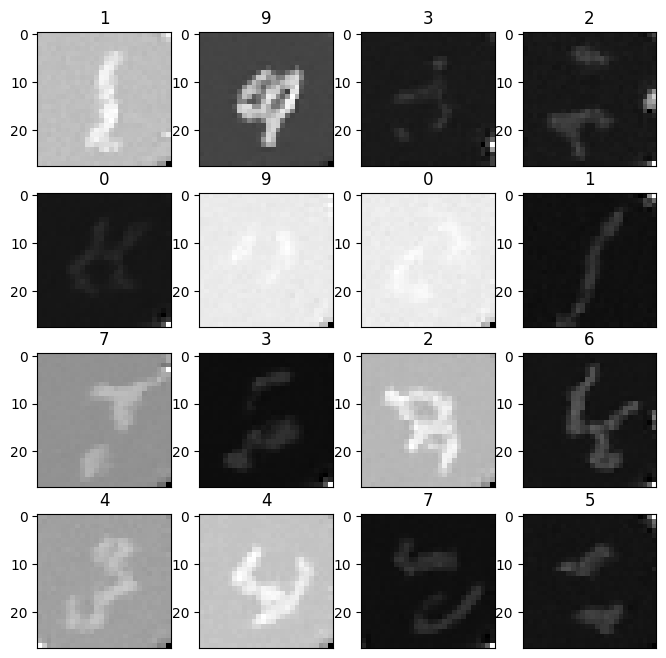

In [164]:
Xs_quad, ys_quad = sample_synthetic(
    diffusion_mnist,
    model_mnist_quad,
    num_samples=16,
    batch = 16,
    shape=(1, 28, 28),
    y_dist = [0.1 for _ in range(10)]
)
show_images(Xs_quad, ys_quad)

Оцените качество насэмплированных картинок.

Качество довольно плохое, в основном получились непонятные кляксы, но где-то можно увидеть очертания нужной цифры. Возможно стоит модель подольше обучить.

## DDIM (0.3 балла)

**ВАЖНО:** В данном задании используется нотация из оригинальной статьи. Оно отличается от нотации выше. А именно, считайте, что ниже $\alpha_t := \sqrt{\bar{\alpha}_t}$. Также $\sigma_t$ ниже тоже отличается (о том, что это, будет написано дальше).

В данной задаче вам предстоит реализовать DDIM сэмплирования. Подробнее читайте тут: [Denoising Diffusion Implicit Models, Song et al., 2020](https://arxiv.org/abs/2010.02502). 

Давайте вкратце опишем, в чем смысл. Идея следущая: давайте изменим прямой диффузионный процесс так, чтобы используя предобученную DDPM, приближать новый обратный процесс за меньшее число шагов. В данном заданее мы не будем ускорять процесс сэмплирования, но реализуем DDIM.

Чтобы не обучать новую модель, нам нужен прямой диффузионный процесс, у которого будет такая же функция потерь (MSE на шум), а обратный процесс все еще останется марковским. Оказалось, что существует целое семейство немарковских прямых процессов, удовлетворяющих этим требования. Это семейство имеет следующий вид (индуцируемое $\sigma \in \mathbb{R}^T$):

![ddim](https://i.imgur.com/lB2KaOR.png)

Распределения выше были выбраны так, чтобы $q(x_t | x_0)$ оставалось таким же, как раньше. Это можно проверить, используя формулу Байеса и свойства нормальных распределений.

Тогда обратный процесс можно переписать как $q_{\sigma}(x_{t-1}|x_t, \hat{x}_{0}(x_t))$ или же:

\begin{equation*}
    x_{t-1} = \sqrt{\alpha_{t-1}} \underbrace{\left(\frac{x_t - \sqrt{1 - \alpha_t} \epsilon_\theta^{(t)}(x_t)}{\sqrt{\alpha_t}}\right)}_{\text{`` predicted } x_0 \text{''}} + \underbrace{\sqrt{1 - \alpha_{t-1} - \sigma_t^2} \cdot \epsilon_\theta^{(t)}(x_t)}_{\text{``direction pointing to } x_t \text{''}} + \underbrace{\sigma_t \epsilon_t}_{\text{random noise}}  \quad \quad \quad \quad \quad \quad (8)
\end{equation*}

Теперь давайте скажем, что $\sigma_t(\eta) = \eta\sqrt{(1 - \alpha_{t - 1})(1 - \alpha_t)}\sqrt{1 - \alpha_t / \alpha_{t - 1}}$, тогда при $\eta = 1$ равенство (8) превращается в DDPM сэмплирование. При $\eta = 0$ у нас $\sigma_t = 0$ и пропадает третья компонента стохастичности, что и называется DDIM сэмплирование. Таким образом, у нас есть детерминистичный процесс сэмплирования: при заданном начальном латенте мы всегда насэмлируем один и тот же $x_0$. Также можно достичь ускорения сэмплирования, выбирая лишь подмножество шагов $0 \leq \tau_1 \leq ... \leq \tau_S \leq T, \ \ \ S < T$ и сэмплируя с помощью DDIM по ним.

Поскольку процесс детерминистичный, то мы можем инвертировать равенство (8) и получить $x_t(x_{t - 1})$, то есть процесс зашумления (reversed DDIM).

Все вышеописанное может быть полезно для осмысленных интерполяций в латентом пространстве (взяли две картинки, сделали обратный DDIM, получили два шума, как-то их проинтерполировали, расшумили DDIM, получили что-то среднее). 


Итак, ниже вам придется реализовать прямой и обратный DDIM. Однако мы не будем интерполировать латенты, а лишь зашумим-расшумим наши картинки. Важно отметить, что нам не нужно переучивать модель, чтобы пользоваться DDIM.

In [151]:
class DiffusionWithDDIM(Diffusion):
    def __init__(self, *args, **kwargs):
        super(DiffusionWithDDIM, self).__init__(*args, **kwargs)

    @torch.no_grad()
    def ddim_step(
        self,
        model_out: torch.FloatTensor,
        x: torch.FloatTensor,
        t: torch.LongTensor,
        eta: float = 0.0
    ):
        """
        Performs ddim step. Use equation (8).
        """

        eps = model_out 

        alpha_bar = torch.sqrt(self.alphas_cumprod)
        alpha_bar_prev = torch.cat([torch.tensor([1.0]), alpha_bar[:-1]], dim=0)
        sigma = eta * torch.sqrt((1 - alpha_bar_prev) * (1 - alpha_bar) * (1 - alpha_bar / alpha_bar_prev))
        
        noise = torch.randn_like(x)
        
        sqrt_alpha_bar_t = _extract_into_tensor(torch.sqrt(alpha_bar), t, x.shape)
        sqrt_alpha_bar_prev_t = _extract_into_tensor(torch.sqrt(alpha_bar_prev), t, x.shape)
        sqrt_one_minus_alphas_bar_t = _extract_into_tensor(torch.sqrt(1 - alpha_bar), t, x.shape)
         
        alpha_bar_prev_t = _extract_into_tensor(alpha_bar_prev, t, x.shape)
        sigma_t = _extract_into_tensor(sigma, t, x.shape)

        mean_pred = (sqrt_alpha_bar_prev_t * (x - sqrt_one_minus_alphas_bar_t * eps) / sqrt_alpha_bar_t + 
                     torch.sqrt(1 - alpha_bar_prev_t - sigma_t ** 2) * eps)

        if t.sum() == 0:
            nonzero_mask = 0.
        else:
            nonzero_mask = 1.
        
        sample = mean_pred + nonzero_mask * sigma_t * noise

        return sample
    
    @torch.no_grad()
    def ddim_sample(
        self,
        model: nn.Module,
        shape: Tuple,
        y_dist: torch.FloatTensor,
        y: torch.LongTensor = None,
        noise: torch.FloatTensor = None,
    ):
        """
        Performs ddim sampling.
        """
        if noise is None:
            x = torch.randn(shape)
        else:
            x = noise

        b = x.shape[0]
        if y is None:
            y = torch.multinomial(
                y_dist,
                num_samples=shape[0],
                replacement=True
            )

        device = x.device
        for t in reversed(range(self.num_timesteps)):
            print(f'Sample timestep {t:4d}', end='\r')
            t_array = (torch.ones(b, device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_step(model_out, x, t_array)
        print()
        return x

    @torch.no_grad()
    def ddim_reverse_step(
        self,
        model_out,
        x,
        t,
        eta=0.0 # dummy
    ):
        """
        Performs DDIM reverse step, i.e. xt from x_{t-1}. Use equation (8) to derive.
        """
        assert eta == 0.0, "Eta must be zero."

        eps = model_out

        alpha_bar = torch.sqrt(self.alphas_cumprod)
        alpha_bar_next = torch.cat([alpha_bar[1:], torch.tensor([0.0]), ], dim=0)

        sqrt_alpha_bar_next_t = _extract_into_tensor(torch.sqrt(alpha_bar_next), t, x.shape)
        sqrt_alpha_bar_t = _extract_into_tensor(torch.sqrt(alpha_bar), t, x.shape)
        sqrt_one_minus_alpha_bar_t = _extract_into_tensor(torch.sqrt(1 - alpha_bar), t, x.shape)
        sqrt_one_minus_alpha_bar_next_t = _extract_into_tensor(torch.sqrt(1 - alpha_bar_next), t, x.shape)

        coef_1 = sqrt_alpha_bar_next_t / sqrt_alpha_bar_t
        
        mean_pred = coef_1 * (x - sqrt_one_minus_alpha_bar_t * eps) + sqrt_one_minus_alpha_bar_next_t * eps
        
        return mean_pred
    
    
    @torch.no_grad()
    def ddim_reverse_sample(
        self,
        model: nn.Module,
        x: torch.FloatTensor,
        y: torch.LongTensor,
    ):
        device = x.device
        
        for t in tqdm(range(self.num_timesteps)):
            t_array = (torch.ones(x.shape[0], device=device) * t).long()
            model_out = model(x, t_array, y)
            x = self.ddim_reverse_step(model_out, x, t_array)
        return x

In [179]:
schedule = 'quad'

In [169]:
diffusion_ddim = DiffusionWithDDIM(
    betas=get_named_beta_schedule(schedule, 1000),
    loss_type="mse"
)

Теперь развернем картинки из прошлого задания и получим латенты $x_T$. И насэмплируем из этих латентов с помощью DDIM.

In [175]:
eps_reveresed = diffusion_ddim.ddim_reverse_sample(model_mnist_quad, Xs_quad.to(device), ys_quad.to(device))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [176]:
Xs_new = diffusion_ddim.ddim_sample(
    model_mnist_quad,
    shape = (1, 28, 28),
    y_dist = torch.tensor([0.1] * 10),
    noise = eps_reveresed.to(model_mnist_linear.device),
    y=ys_quad.to(model_mnist_linear.device)
)

Sample timestep    0


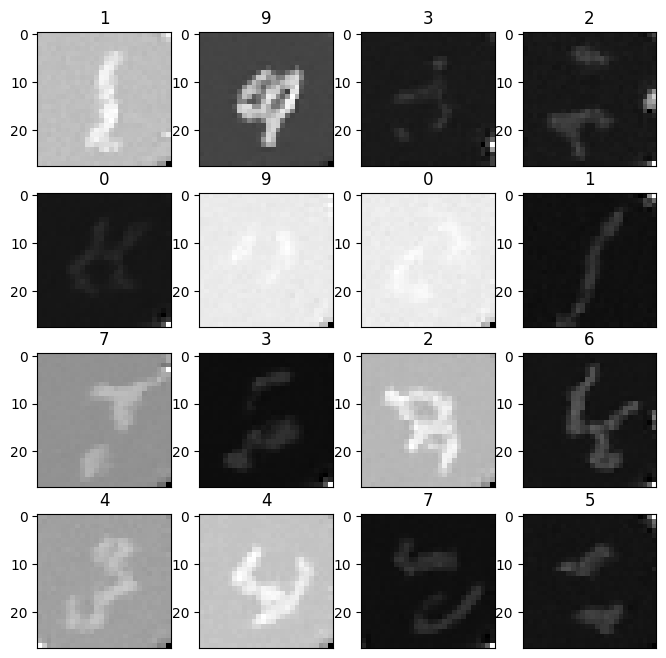

In [177]:
show_images(Xs_quad, ys_quad)

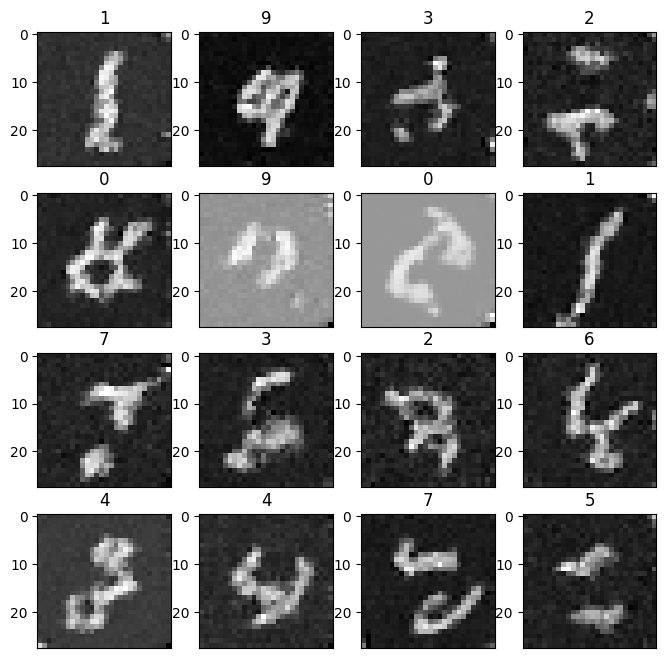

In [178]:
show_images(Xs_new, ys_quad)

Оцените полученные сэмплы. Идеально ли они восстановились? Если нет, то почему? Пункт оценивается.

Сэмплы восстановились явно не идеально, возсможно стоит ещё дообучить модель.